We want to show the Electric, Magnetic, and Pixel Intensity from Swarm B

In [273]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp



In [274]:
time_array=(datetime(2022,12,19,14,4), datetime(2022,12,19,14,6))

In [275]:
#From documentation link
def requester(sc_collection, measurement, residual, sampling_step=None, **kwargs):
    try:
        request = SwarmRequest()
        request.set_collection(sc_collection)
        if residual == True:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                residuals=True,
                sampling_step=sampling_step,
            )
        else:
            request.set_products(
                measurements=measurement,
                models=["CHAOS"],
                sampling_step=sampling_step,
            )
        data = request.get_between(time_array[0], time_array[1], **kwargs) #sets to get data between the first and last value in the time tuple
        df = data.as_dataframe()
    except:
        df = []
    return df

In [276]:
def arrangement(time, array, shape):  # arranges B into a useable format for use later
    barranged = np.zeros((len(time), shape))
    # Re-arranges into proper (n x 3 ) matricies, ugly but works
    for j in range(len(time)):
        for k in range(shape):
            barranged[j][k] = array[j][k]
    return barranged

In [277]:
def unit_array(array):
    arraysum = np.sum(np.abs(array), axis=1)
    # Normalizes and finds unitary
    array_unit = array / arraysum[:, np.newaxis]  # normalizes
    return array_unit

In [278]:
#Lets do B first
ds = requester( 
    "SW_OPER_MAGB_HR_1B", #Mag B, high resolution, 50Hz B (Magnetic field)
    "B_NEC", #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) #cadence of 10 to match our images, in practice this selects every 10th data point since the resolution is 1 sample a second (sps)
print(ds)
BNEC=ds["B_NEC_res_CHAOS"]
time = BNEC.index.to_numpy()
BNEC = arrangement(time, ds["B_NEC_res_CHAOS"], 3)




                                                                 B_NEC_res_CHAOS  \
Timestamp                                                                          
2022-12-19 14:04:00.010546923  [82.78851767348624, -138.16134622453387, 36.38...   
2022-12-19 14:04:00.030546904  [82.75096559278973, -138.28340700805347, 36.37...   
2022-12-19 14:04:00.050546885  [82.6129967472325, -138.48937014403464, 36.388...   
2022-12-19 14:04:00.070546865  [82.54693945306826, -138.7562176351937, 36.417...   
2022-12-19 14:04:00.090546846  [82.52484444328365, -139.05127858931246, 36.41...   
...                                                                          ...   
2022-12-19 14:05:59.902414083  [10.672619929264329, 15.12969049616413, -9.467...   
2022-12-19 14:05:59.922414064  [10.6323925845536, 15.15063925961067, -9.47605...   
2022-12-19 14:05:59.942414045  [10.628683967614052, 15.20196943415067, -9.441...   
2022-12-19 14:05:59.962414026  [10.611746169222897, 15.266420895678039, -9.4

C:\Users\1101w\AppData\Local\Temp\ipykernel_18956\2246279540.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  barranged[j][k] = array[j][k]


In [279]:
measurements_E = [
        "VsatN",
        "VsatE",
        "VsatC",
        "Evx",
        "Evy",
        "Evz",
        "Quality_flags",
    ]
ds = requester( 
    "SW_EXPT_EFIB_TCT16", #Mag B, high resolution, 50Hz B (Magnetic field)
    measurements_E, #Magnetic field in NEC coordinates
    True, 
    asynchronous=False,
    show_progress=False) #cadence of 10 to match our images, in practice this selects every 10th data point since the resolution is 1 sample a second (sps)
velocity=np.array([ds["VsatN"], ds["VsatE"], ds["VsatC"]]) #We need the velocities of the satellite in NEC so we can get the unit vector and then get our Electric field 
velocity_unit=unit_array(velocity) #function that gives the unitary vector
ENEC=np.multiply(np.array([ds["Evx"], ds["Evy"], ds["Evz"]]), velocity_unit) #In this event the vertical sensor is better #https://efi.phys.ucalgary.ca/SwarmMovies/showVideo.php?video=202212/SW_OPER_EFIBTIIMOV_20221219T000000_20221219T235959_0101.mp4&size=10931
time = ds.index.to_numpy()



Now for the hard part, the pixel intensity
Since the satellite as seen in figure 1 passes through the arc pretty fast, we should increase the resolution of the pixel intensity by super imposing 

Lets define the imager

In [280]:
latitude, longitude, altitude = ds['Latitude'].to_numpy(), ds['Longitude'].to_numpy(),  (ds["Radius"].to_numpy()-6.371e6)/1e3 #km  # Gets Emphermis data

alt=110

In [281]:
asi=asilib.asi.trex_rgb(location_code='yknf', alt=110, time_range=time_array, colors='r')


In [282]:
t1 = time_array[0]
t0 = datetime(1970,1,1)
ut = (t1-t0).total_seconds()
lat_sat=np.deg2rad(latitude)
lon_sat=np.deg2rad(longitude)
gp.recalc(ut)
print(altitude)
r, theta= gp.geodgeo(altitude,lat_sat,1) #TODO magically, r is 10km less than if you calculated r manually, is this real

x_gc,y_gc,z_gc = gp.sphcar((r)/6371,theta,lon_sat,1)  #spherical to cartesian
 

x_gsm, y_gsm, z_gsm = gp.geogsm(x_gc,y_gc,z_gc, 1) #cartesian to gsm

x_foot,y_foot,z_foot=np.zeros(len(x_gsm)), np.zeros(len(y_gsm)), np.zeros(len(z_gsm)) #initalize an array


[501.232  501.2325 501.233  ... 502.201  502.2015 502.202 ]


In [283]:
for index in range(len(x_gsm)):
    x_foot_int, y_foot_int, z_foot_int, xx, _,zz = gp.trace(x_gsm[index], y_gsm[index], z_gsm[index], dir=1,rlim=2, r0=(alt-10+6371)/6371, maxloop=300 ) #traces each set of lat,lon,alt outward
    _, _, _, xx2,yy2,zz2 = gp.trace(x_foot_int, y_foot_int, z_foot_int, dir=-1,rlim=100, r0=(alt-10+6371)/6371, maxloop=1000 )#Traces inward
    def curve_fit_func():
        def cubic(t, a, b, c, d):
            return a*t**3 + b*t**2 + c*t + d
        r = np.linspace(1, 1.5, 100000)

        radius_data=np.sqrt(xx2**2+yy2**2+zz2**2)

        params_x, _ = curve_fit(cubic, radius_data, xx2) #Constructs fits on the traces inward since the spatial resolution produced by geopack is limited.
        params_y, _ = curve_fit(cubic, radius_data, yy2)
        params_z, _ = curve_fit(cubic, radius_data, zz2)

        def x(t):
            return cubic(t, *params_x)

        def y(t):
            return cubic(t, *params_y)

        def z(t):
            return cubic(t, *params_z)
        def radius(t):
            return np.sqrt(x(t)**2 + y(t)**2 + z(t)**2)

        index_closest=np.argmin(np.abs(radius(r)-(alt-10+6371)/6371))

        return x(r[index_closest]),y(r[index_closest]),z(r[index_closest])

    x_foot[index],y_foot[index],z_foot[index] = curve_fit_func()

x_done, y_done, z_done = gp.geogsm(x_foot, y_foot, z_foot, -1)

alt_sat_done, lat_sat_done,lon_sat_done = np.zeros(len(x_done)), np.zeros(len(x_done)), np.zeros(len(x_done))
for index in range(len(x_done)):
    
    r_done,theta_done,lon_sat_done[index]= gp.sphcar(x_done[index], y_done[index], z_done[index],-1)

    alt_sat_done[index], lat_sat_done[index]= gp.geodgeo(r_done*6371,theta_done,-1) #TODO check if this is right

print(alt_sat_done, 'altitude derived from fit')

if np.any(np.abs(alt_sat_done - alt) > 5):
    raise Exception("One or more values in the footprinting are greater than 5km away from the specified alt. Contact owner for a fix, not your fault")
print(np.rad2deg(lon_sat_done)-360,np.rad2deg(lat_sat_done) , 'lat and lon' )
sat_lla=np.array([np.rad2deg(lat_sat_done), np.rad2deg(lon_sat_done)-360, alt_sat_done]).T

conjunction_obj = asilib.Conjunction(asi, (np.array(time), sat_lla))

In [ ]:
#Now lets 

[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]


 [[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  ...

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]
   ...
   [0

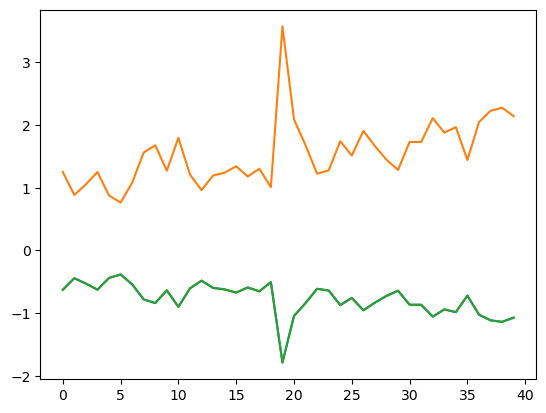

In [ ]:
sat_azimuth_elevation, sat_azel_pixels = conjunction_obj.map_azel()
area_intensity = conjunction_obj.intensity(box=(20, 20))
area_mask = conjunction_obj.equal_area(box=(20,20))
# Need to change masked NaNs to 0s so we can plot the rectangular area contours.
area_mask[np.where(np.isnan(area_mask))] = 0
#plt.plot(area_intensity) #This gives us a resolution of 3Hz.
print(area_mask)
len(area_intensity)
from scipy.signal import detrend

plt.plot(detrend(area_intensity))

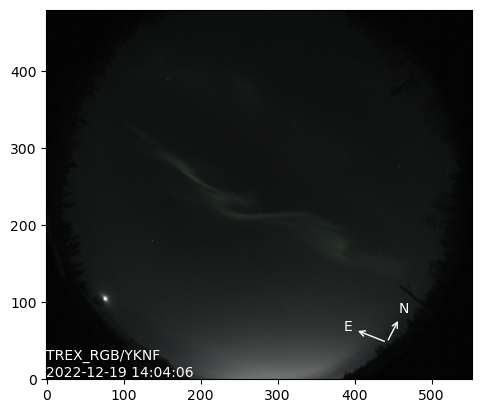

In [ ]:
fig, ax = plt.subplots()
asi_single=asilib.asi.trex_rgb(location_code='yknf', alt=110, time=datetime(2022,12,19,14,4,5), colors='rgb')

ax, im = asi_single.plot_fisheye(ax=ax)


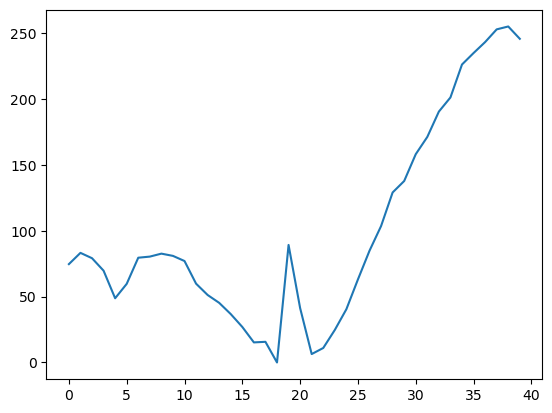

In [ ]:
processed_array = remove_gradient_from_array(area_intensity[:,1])
plt.plot(processed_array)

In [ ]:
def non_zero_indices(array):
    # Convert the array to a numpy array if it isn't already
    np_array = np.array(array)
    # Find the indices of non-zero elements
    indices = np.transpose(np.nonzero(np_array))
    return indices

# Example usage:
array = [
    [0, 1, 2],
    [0, 4, 0],
    [5, 0, 0]
]
print("Indices where array does not contain 0:\n", non_zero_indices(area_mask[20, :, :, 1]))

Indices where array does not contain 0:
 [[132 418]
 [132 419]
 [132 420]
 [132 421]
 [132 422]
 [132 423]
 [132 424]
 [133 413]
 [133 414]
 [133 415]
 [133 416]
 [133 417]
 [133 418]
 [133 419]
 [133 420]
 [133 421]
 [133 422]
 [133 423]
 [133 424]
 [134 413]
 [134 414]
 [134 415]
 [134 416]
 [134 417]
 [134 418]
 [134 419]
 [134 420]
 [134 421]
 [134 422]
 [134 423]
 [134 424]
 [134 425]
 [135 414]
 [135 415]
 [135 416]
 [135 417]
 [135 418]
 [135 419]
 [135 420]
 [135 421]
 [135 422]
 [135 423]
 [135 424]
 [135 425]
 [136 414]
 [136 415]
 [136 416]
 [136 417]
 [136 418]
 [136 419]
 [136 420]
 [136 421]
 [136 422]
 [136 423]
 [136 424]
 [136 425]
 [136 426]
 [137 415]
 [137 416]
 [137 417]
 [137 418]
 [137 419]
 [137 420]
 [137 421]
 [137 422]
 [137 423]
 [137 424]
 [137 425]
 [137 426]
 [137 427]
 [138 416]
 [138 417]
 [138 418]
 [138 419]
 [138 420]
 [138 421]
 [138 422]
 [138 423]
 [138 424]
 [138 425]
 [138 426]
 [138 427]
 [139 416]
 [139 417]
 [139 418]
 [139 419]
 [139 420]
 [

In [ ]:
import cv2
def remove_gradient_from_image(image):
    # Separate the image into its R, G, B components
    r, g, b = cv2.split(image)
    
    # Estimate and remove the gradient for each channel
    r_blurred = cv2.GaussianBlur(r, (51, 51), 0)
    g_blurred = cv2.GaussianBlur(g, (51, 51), 0)
    b_blurred = cv2.GaussianBlur(b, (51, 51), 0)
    
    r_processed = cv2.addWeighted(r, 1.5, r_blurred, -0.5, 0)
    g_processed = cv2.addWeighted(g, 1.5, g_blurred, -0.5, 0)
    b_processed = cv2.addWeighted(b, 1.5, b_blurred, -0.5, 0)
    
    # Merge the channels back into a single image
    processed_image = cv2.merge([r_processed, g_processed, b_processed])
    
    return processed_image

(479, 120, 3)


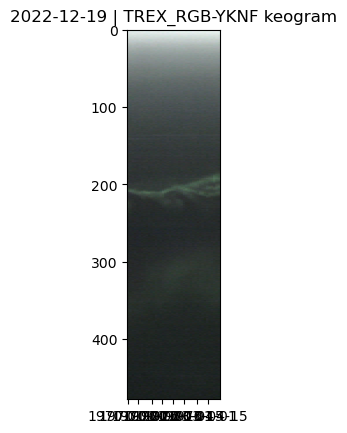

In [ ]:
axes,im = asi.plot_keogram()
im_array = im.get_array()
print(np.shape(im_array))
plt.imshow(im_array)



C:\Users\1101w\AppData\Local\Temp\ipykernel_18956\65357645.py:32: RuntimeWarning: overflow encountered in expm1
  img_homomorphic = np.expm1(img_back)
C:\Users\1101w\AppData\Local\Temp\ipykernel_18956\65357645.py:37: RuntimeWarning: invalid value encountered in cast
  return img_homomorphic.astype(np.uint8)


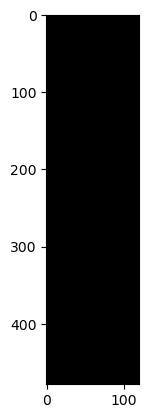

In [ ]:
plt.imshow(remove_gradient_from_image(im_array))